# Akeed Restaurant Recommendation Challenge

## Importing libraries:

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import psycopg2
import geopandas as gpd
from shapely import wkt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from copy import deepcopy, copy

## Inspecting the base layers:

### Reference Layers

In [31]:
#Postgis Layer
con = psycopg2.connect(host="localhost", database="vulcan", port="6666", user="tebogo", password="tebogo")
countries_sql = "SELECT * FROM public.countries WHERE cntry_name = 'Oman'"
countries_gdf = gpd.GeoDataFrame.from_postgis(countries_sql, con, geom_col='geom')

### Base Layer 1

In [2]:
#Training Locations
training_locations = pd.read_csv("./train_locations.csv")
print("\n This table has " + str(len(training_locations)) + " rows.")
training_locations.head()
#training_locations.isnull().sum()


 This table has 59503 rows.


,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


### Base Layer 2

In [3]:
#Training Customers
training_customers = pd.read_csv("./train_customers.csv")
print("\n This table has " + str(len(training_customers)) + " rows.")
training_customers.head()
#training_customers.isnull().sum()


 This table has 34674 rows.


,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


### Base Layer 3

In [4]:
#Orders
orders = pd.read_csv("./orders.csv")
print("\n This table has " + str(len(orders)) + " rows.")
orders.head()
#orders.isnull().sum()


 This table has 135303 rows.


/home/kusasa/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


### Base Layer 4

In [5]:
#Vendors
vendors = pd.read_csv("./vendors.csv")
print("\n This table has " + str(len(vendors)) + " rows.")
vendors.head()
#vendors.isnull().sum()


 This table has 100 rows.


,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


## Pre-process tables where need be

### Add valuable calculated fields

In [6]:
#Add geometry field to the training locations table
geometry = [Point(xy) for xy in zip(training_locations.longitude, training_locations.latitude)]
crs = {'init': 'epsg:4326'} #crs assumed
training_locations_gdf = gpd.GeoDataFrame(training_locations, crs=crs, geometry=geometry)

In [7]:
#Add geometry field to the vendors table
geometry = [Point(xy) for xy in zip(vendors.longitude, vendors.latitude)]
crs = {'init': 'epsg:4326'} #crs assumed
vendors_gdf = gpd.GeoDataFrame(vendors, crs=crs, geometry=geometry)
vendors_gdf.head

<bound method NDFrame.head of      id  authentication_id   latitude  longitude vendor_category_en  \
0     4           118597.0  -0.588596   0.754434        Restaurants   
1    13           118608.0  -0.471654   0.744470        Restaurants   
2    20           118616.0  -0.407527   0.643681        Restaurants   
3    23           118619.0  -0.585385   0.753811        Restaurants   
4    28           118624.0   0.480602   0.552850        Restaurants   
..  ...                ...        ...        ...                ...   
95  849           130455.0  -1.588060  -0.066441        Restaurants   
96  855           130463.0   2.145206   0.745025        Restaurants   
97  856           130464.0   0.251469   0.483632        Restaurants   
98  858           130468.0   0.019817   0.587087        Restaurants   
99  907           132953.0  13.335131  -1.449556        Restaurants   

    vendor_category_id  delivery_charge  serving_distance  is_open  \
0                  2.0              0.0        

### Deal with null values

In [8]:
#Training Locations
training_locations_gdf['location_type'] = training_locations_gdf['location_type'].fillna(value="unknown")
training_locations_gdf.head()

,customer_id,location_number,location_type,latitude,longitude,geometry
0,02SFNJH,0,unknown,1.682392,-78.789737,POINT (-78.78974 1.68239)
1,02SFNJH,1,unknown,1.679137,0.766823,POINT (0.76682 1.67914)
2,02SFNJH,2,unknown,-0.498648,0.661241,POINT (0.66124 -0.49865)
3,RU43CXC,0,Home,0.100853,0.438165,POINT (0.43817 0.10085)
4,BDFBPRD,0,unknown,2.523125,0.733464,POINT (0.73346 2.52313)


In [9]:
#Training Customers
training_customers = training_customers.fillna(value="unknown")
training_customers.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,unknown,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,unknown,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,unknown,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,unknown,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,unknown,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


In [10]:
#Orders
orders = orders.fillna(value="unknown")
orders.head()

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238,92PEE24,1,7.6,2,unknown,0.0,unknown,unknown,No,...,unknown,unknown,unknown,unknown,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,unknown,92PEE24 X 0 X 105
1,163240,QS68UD8,1,8.7,1,unknown,0.0,unknown,unknown,No,...,unknown,unknown,unknown,unknown,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241,MB7VY5F,2,14.4,1,unknown,0.0,unknown,unknown,No,...,unknown,unknown,unknown,unknown,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,unknown,MB7VY5F X 0 X 83
3,163244,KDJ951Y,1,7.1,1,unknown,0.0,unknown,unknown,No,...,unknown,unknown,unknown,unknown,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245,BAL0RVT,4,27.2,1,unknown,0.0,unknown,unknown,No,...,unknown,unknown,unknown,unknown,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [11]:
#Vendors
vendors_gdf['language'] = vendors_gdf['language'].fillna(value="unknown")
vendors_gdf.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,geometry
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1,POINT (0.75443 -0.58860)
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1,POINT (0.74447 -0.47165)
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1,POINT (0.64368 -0.40753)
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1,POINT (0.75381 -0.58538)
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1,POINT (0.55285 0.48060)


### Compose focus training table

In [44]:
# Composed training table
training_table = pd.DataFrame()
training_table["akeed_order_id"] = orders["akeed_order_id"]
training_table["customer_id"] = orders["customer_id"]
training_table["vendor_id"] = orders["vendor_id"]
"""Continue building out training table"""

'Continue building out training table'

### Deal with mixed data-type fields in training table

In [12]:
#find mixed data type columns
for col in orders.columns:
    weird = (orders[[col]].applymap(type) != orders[[col]].iloc[0].apply(type)).any(axis=1)
    if len(orders[weird]) > 0:
        print(col)

akeed_order_id
item_count
promo_code_discount_percentage
vendor_rating
preparationtime


In [13]:
#find mixed data type cells
weird = (orders.applymap(type) != orders.iloc[0].apply(type)).any(axis=1)
orders[weird].isin([1]).sum()
'''Find and replace cell types'''

'Find and replace cell types'

### Encode nominal fields in training table

In [14]:
#Location Type column in Training Locations
training_locations_gdf.groupby(['location_type']).first()
dummy = pd.get_dummies(training_locations_gdf['location_type'])
encoded_training_locations_gdf = training_locations_gdf.merge(dummy, left_index=True, right_index=True)
encoded_training_locations_gdf.head()

,customer_id,location_number,location_type,latitude,longitude,geometry,Home,Other,Work,unknown
0,02SFNJH,0,unknown,1.682392,-78.789737,POINT (-78.78974 1.68239),0,0,0,1
1,02SFNJH,1,unknown,1.679137,0.766823,POINT (0.76682 1.67914),0,0,0,1
2,02SFNJH,2,unknown,-0.498648,0.661241,POINT (0.66124 -0.49865),0,0,0,1
3,RU43CXC,0,Home,0.100853,0.438165,POINT (0.43817 0.10085),1,0,0,0
4,BDFBPRD,0,unknown,2.523125,0.733464,POINT (0.73346 2.52313),0,0,0,1


In [45]:
#Gender column in Training Customers
training_customers.groupby(['gender']).first()
training_customers['gender'] = training_customers['gender'].str.upper()
training_customers['gender'] = training_customers['gender'].str.strip()
dummy = pd.get_dummies(training_customers['gender'])
encoded_training_customers = training_customers.merge(dummy, left_index=True, right_index=True)
encoded_training_customers.head()

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at,,?????,FEMALE,MALE,UNKNOWN
0,TCHWPBT,MALE,unknown,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23,0,0,0,1,0
1,ZGFSYCZ,MALE,unknown,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41,0,0,0,1,0
2,S2ALZFL,MALE,unknown,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42,0,0,0,1,0
3,952DBJQ,MALE,unknown,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07,0,0,0,1,0
4,1IX6FXS,MALE,unknown,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01,0,0,0,1,0


### Feature Scale field values if need be, in training table

In [16]:
#sc = StandardScaler()
#scaled_X = sc.fit_transform(X)

## Exploring Relationships using plots

### Exploration 1

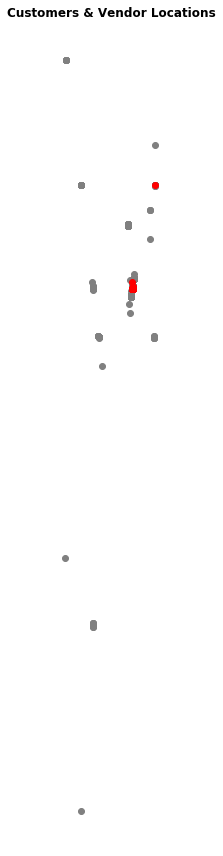

In [38]:
#Spatial Relations

ax = encoded_training_locations_gdf.plot(color = 'grey', figsize = (18, 12), legend=True)
vendors_gdf.plot(ax=ax, color = 'red')
#countries_gdf.plot(ax=ax, edgecolor = 'grey', facecolor = 'none')
#ax.set(xlim=(15, 35), ylim=(-37.5, -20))
ax.set_axis_off()
plt.title(label = 'Customers & Vendors Locations', fontweight = 'bold')
plt.tight_layout()

### Exploration 2

In [ ]:
# Linear Relations



## Prediction Modelling